In [ ]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.1'

In [ ]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


We download the data

In [ ]:
FILEID='17BB2Ufj-9rTnT9cwZR8fu_sKKGdCXLxM'
FILENAME='train.zip'
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILEID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILEID" -O $FILENAME && rm -rf /tmp/cookies.txt

--2020-07-23 15:10:32--  https://docs.google.com/uc?export=download&confirm=g5YS&id=17BB2Ufj-9rTnT9cwZR8fu_sKKGdCXLxM
Resolving docs.google.com (docs.google.com)... 108.177.13.100, 108.177.13.113, 108.177.13.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.13.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-ac-docs.googleusercontent.com/docs/securesc/vfeubb1vrhgbfq7jpgvv0p6000p2nt7i/keg0t33arbdb7udreo93ft7a15r76fbo/1595517000000/12308918870841825745/04025891841376548254Z/17BB2Ufj-9rTnT9cwZR8fu_sKKGdCXLxM?e=download [following]
--2020-07-23 15:10:32--  https://doc-0o-ac-docs.googleusercontent.com/docs/securesc/vfeubb1vrhgbfq7jpgvv0p6000p2nt7i/keg0t33arbdb7udreo93ft7a15r76fbo/1595517000000/12308918870841825745/04025891841376548254Z/17BB2Ufj-9rTnT9cwZR8fu_sKKGdCXLxM?e=download
Resolving doc-0o-ac-docs.googleusercontent.com (doc-0o-ac-docs.googleusercontent.com)... 172.217.203.132, 2607:f8b0:400c:c07::84
Connectin

In [ ]:
ls -lh

total 33M
drwxr-xr-x 1 root root 4.0K Jul 10 16:29 sample_data/
-rw-r--r-- 1 root root  33M Jul 23 15:10 train.zip


In [ ]:
!unzip -q train.zip -d kaggle_original_data

In [ ]:
!rm -r kaggle_original_data/__MACOSX/

In [ ]:
!ls -l kaggle_original_data | head

total 8
drwxr-xr-x 2 root root 4096 Jul 22 20:17 clean
drwxr-xr-x 2 root root 4096 Jul 22 20:17 messy


We now are going to sort the images by separating them into different folders.

In [ ]:
from random import shuffle
import os, shutil

# list all labels
label_dirs = ['clean', 'messy']

# The path to the directory where the original
# dataset was uncompressed
original_dataset_dir = '/content/kaggle_original_data'

# The directory where we will
# store our smaller dataset
base_dir = '/content/messy_vs_clean_room'
os.mkdir(base_dir)

# Directories for our training,
# validation and test splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# Directory with our training/validation/test label pictures
for target_dir in [train_dir, validation_dir, test_dir]:
    for label in label_dirs:
        dir = os.path.join(target_dir, label)
        os.mkdir(dir)

# Copy 70% of each label to train, 15% to valid, and 15% to test directories
for label in label_dirs:
    fnames = os.listdir(os.path.join(original_dataset_dir, label))
    shuffle(fnames)  # shuffling the list
    n_img_start_valid = int(len(fnames)*0.7)
    n_img_start_test  = int(len(fnames)*0.85)
    for fname in fnames[:n_img_start_valid]:  # train
        src = os.path.join(original_dataset_dir, label, fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)
    for fname in fnames[n_img_start_valid:n_img_start_test]:  # valid
        src = os.path.join(original_dataset_dir, label, fname)
        dst = os.path.join(validation_dir, label, fname)
        shutil.copyfile(src, dst)
    for fname in fnames[n_img_start_test:]:  # test
        src = os.path.join(original_dataset_dir, label, fname)
        dst = os.path.join(test_dir, label, fname)
        shutil.copyfile(src, dst)

We check how many images each(train/vali/test) has.

In [ ]:
total_train_imgs = 0
total_valid_imgs = 0
for label in label_dirs:
    print('total images for label', label, 'in training:', len(os.listdir(os.path.join(train_dir, label))),
                                           'in valid:', len(os.listdir(os.path.join(validation_dir, label))),
                                            'in test:', len(os.listdir(os.path.join(test_dir, label))))
    total_train_imgs += len(os.listdir(os.path.join(train_dir, label)))
    total_valid_imgs += len(os.listdir(os.path.join(validation_dir, label)))

total images for label clean in training: 74 in valid: 16 in test: 16
total images for label messy in training: 74 in valid: 16 in test: 16


In [ ]:
print('Total number of training images:', total_train_imgs)
print('Total number of validation images:', total_valid_imgs)

Total number of training images: 148
Total number of validation images: 32


We build our model by keras with 4 Conv2D + MaxPooling2D layers and 2 dense layers.

In [ ]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
model.summary()

We compile loss function, optimizer, and metric into the model.

In [ ]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

We change the image into the range [0,1] by ImageDataGenerator. Then we produce the training, testing, validation data.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 148 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Now we begin to train our model.

In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 10s 101ms/step - loss: 0.5283 - acc: 0.7274 - val_loss: 0.4134 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 11s 107ms/step - loss: 0.3404 - acc: 0.8639 - val_loss: 0.8140 - val_acc: 0.7188
Epoch 3/30
100/100 [==============================] - 11s 110ms/step - loss: 0.2346 - acc: 0.9143 - val_loss: 0.8827 - val_acc: 0.7500
Epoch 4/30
100/100 [==============================] - 11s 107ms/step - loss: 0.1304 - acc: 0.9596 - val_loss: 0.8549 - val_acc: 0.7812
Epoch 5/30
100/100 [==============================] - 11s 105ms/step - loss: 0.0670 - acc: 0.9811 - val_loss: 1.0388 - val_acc: 0.7188
Epoch 6/30
100/100 [==============================] - 10s 103ms/step - loss: 0.0471 - acc: 0.9870 - val_loss: 0.7218 - val_acc: 0.6875
Epoch 7/30
100/100 [==============================] - 11s 108ms/step - loss: 0.0490 - acc: 0.9881 - val_loss: 1.4416 - val_acc: 0.8125
Epoch 8/30
100/100 [==============================] - 1

In [ ]:
model.save('clean_and_messy_1.h5')

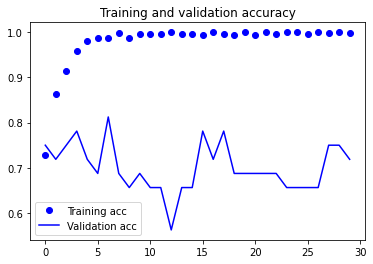

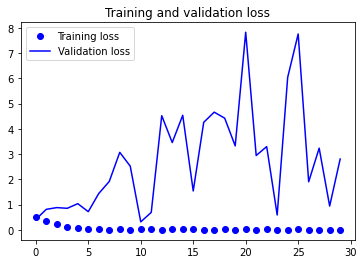

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

The result shows that the model has overfitting problems, so we use data augmentation to expand our dataset.

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

We train the second model again, but we use dropout this time to improve the validation rate.

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 148 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 29s 294ms/step - loss: 0.3713 - acc: 0.8358 - val_loss: 0.7610 - val_acc: 0.7188
Epoch 2/30
100/100 [==============================] - 29s 288ms/step - loss: 0.3814 - acc: 0.8358 - val_loss: 0.4863 - val_acc: 0.7812
Epoch 3/30
100/100 [==============================] - 29s 289ms/step - loss: 0.3451 - acc: 0.8551 - val_loss: 0.7489 - val_acc: 0.7188
Epoch 4/30
100/100 [==============================] - 29s 288ms/step - loss: 0.3187 - acc: 0.8733 - val_loss: 0.4863 - val_acc: 0.7500
Epoch 5/30
100/100 [==============================] - 28s 285ms/step - loss: 0.3149 - acc: 0.8706 - val_loss: 0.5379 - val_acc: 0.7812
Epoch 6/30
100/100 [==============================] - 29s 294ms/step - loss: 0.2977 - acc: 0.8682 - val_loss: 0.5615 - val_acc: 0.7500
Epoch 7/30
100/100 [==============================] - 32s 317ms/step - loss: 0.2857 - acc: 0.8804 - val_loss:

In [ ]:
model.save('clean_and_messy_aug.h5')

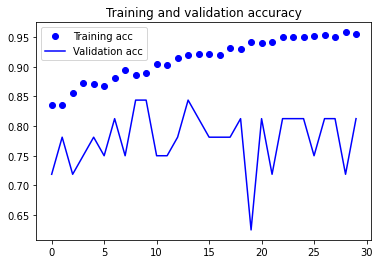

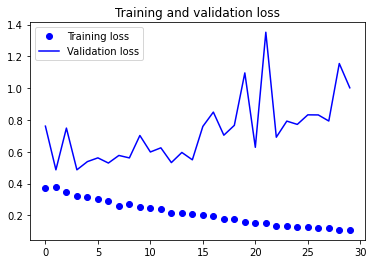

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We remove two layers this time.

In [ ]:
# remove 2 layers
smaller_model = models.Sequential()
smaller_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
smaller_model.add(layers.MaxPooling2D((2, 2)))
smaller_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
smaller_model.add(layers.MaxPooling2D((2, 2)))
smaller_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
smaller_model.add(layers.MaxPooling2D((2, 2)))
#smaller_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
#smaller_model.add(layers.MaxPooling2D((2, 2)))
smaller_model.add(layers.Flatten())
smaller_model.add(layers.Dropout(0.5))
smaller_model.add(layers.Dense(64, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [ ]:
smaller_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 17, 17, 32)        0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 9248)            

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

history = smaller_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 148 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 30s 303ms/step - loss: 0.5874 - acc: 0.7115 - val_loss: 0.5397 - val_acc: 0.7500
Epoch 2/30
100/100 [==============================] - 29s 293ms/step - loss: 0.4737 - acc: 0.7814 - val_loss: 0.4854 - val_acc: 0.8125
Epoch 3/30
100/100 [==============================] - 29s 292ms/step - loss: 0.4612 - acc: 0.7892 - val_loss: 0.4847 - val_acc: 0.7812
Epoch 4/30
100/100 [==============================] - 30s 297ms/step - loss: 0.4407 - acc: 0.8027 - val_loss: 0.4977 - val_acc: 0.7812
Epoch 5/30
100/100 [==============================] - 30s 303ms/step - loss: 0.4374 - acc: 0.8122 - val_loss: 0.6100 - val_acc: 0.7812
Epoch 6/30
100/100 [==============================] - 30s 298ms/step - loss: 0.4377 - acc: 0.8074 - val_loss: 0.4927 - val_acc: 0.7812
Epoch 7/30
100/100 [==============================] - 30s 295ms/step - loss: 0.4106 - acc: 0.8186 - val_loss:

In [ ]:
smaller_model.save('clean_and_messy_smaller.h5')

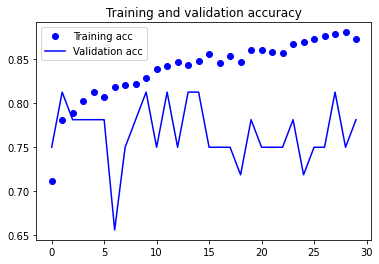

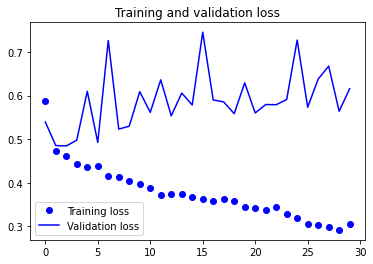

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = smaller_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 32 images belonging to 2 classes.
test acc: 0.78125


We use VGG16 model this time to improve the performance of our model.

In [ ]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
from keras import models
from keras import layers

VGG16_model = models.Sequential()
VGG16_model.add(conv_base)
VGG16_model.add(layers.Flatten())
VGG16_model.add(layers.Dense(256, activation='relu'))
VGG16_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
VGG16_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(VGG16_model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 30


In [ ]:
conv_base.trainable = False

In [ ]:
print('This is the number of trainable weights '
      'after freezing the conv base:', len(VGG16_model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

VGG16_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history = VGG16_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Found 148 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Epoch 1/30
 - 35s - loss: 0.3727 - acc: 0.8726 - val_loss: 0.3252 - val_acc: 0.9062
Epoch 2/30
 - 26s - loss: 0.1941 - acc: 0.9472 - val_loss: 0.3999 - val_acc: 0.9062
Epoch 3/30
 - 26s - loss: 0.1580 - acc: 0.9490 - val_loss: 0.2427 - val_acc: 0.9062
Epoch 4/30
 - 26s - loss: 0.1243 - acc: 0.9666 - val_loss: 0.3524 - val_acc: 0.9375
Epoch 5/30
 - 26s - loss: 0.1133 - acc: 0.9628 - val_loss: 0.0677 - val_acc: 0.9375
Epoch 6/30
 - 26s - loss: 0.0835 - acc: 0.9745 - val_loss: 0.2308 - val_acc: 0.9375
Epoch 7/30
 - 26s - loss: 0.0832 - acc: 0.9725 - val_loss: 0.3256 - val_acc: 0.9062
Epoch 8/30
 - 26s - loss: 0.0797 - acc: 0.9783 - val_loss: 0.2916 - val_acc: 0.9375
Epoch 9/30
 - 26s - loss: 0.0712 - acc: 0.9751 - val_loss: 0.2454 - val_acc: 0.9062
Epoch 10/30
 - 26s - loss: 0.0679 - acc: 0.9795 - val_loss: 0.1050 - val_acc: 0.9062
Epoch 11/30
 - 26s - loss: 0.0619 - acc: 0.9821 - val_loss: 0.4610 - val_acc: 

In [ ]:
VGG16_model.save('clean_and_messy_VGG16.h5')

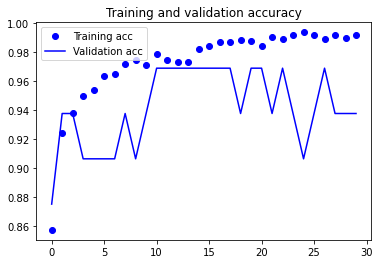

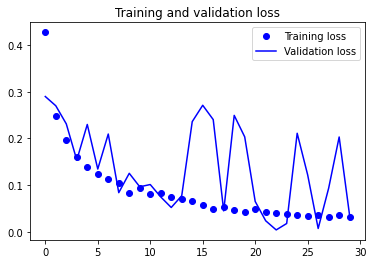

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = VGG16_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 32 images belonging to 2 classes.
test acc: 0.96875


---

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
from keras import models
from keras import layers

VGG16_FT_model = models.Sequential()
VGG16_FT_model.add(conv_base)
VGG16_FT_model.add(layers.Flatten())
VGG16_FT_model.add(layers.Dense(256, activation='relu'))
VGG16_FT_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to 150x150
        target_size=(150, 150),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

VGG16_FT_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = VGG16_FT_model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Found 148 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Epoch 1/30
100/100 [==============================] - 22s 215ms/step - loss: 0.0631 - acc: 0.9817 - val_loss: 0.4494 - val_acc: 0.9062
Epoch 2/30
100/100 [==============================] - 21s 208ms/step - loss: 0.0079 - acc: 0.9978 - val_loss: 0.1541 - val_acc: 0.8750
Epoch 3/30
100/100 [==============================] - 20s 203ms/step - loss: 0.0041 - acc: 0.9989 - val_loss: 0.7673 - val_acc: 0.9062
Epoch 4/30
100/100 [==============================] - 21s 208ms/step - loss: 0.0028 - acc: 0.9984 - val_loss: 1.3237 - val_acc: 0.8750
Epoch 5/30
100/100 [==============================] - 20s 205ms/step - loss: 0.0012 - acc: 0.9995 - val_loss: 0.5445 - val_acc: 0.8750
Epoch 6/30
100/100 [==============================] - 21s 208ms/step - loss: 0.0034 - acc: 0.9989 - val_loss: 0.0712 - val_acc: 0.9375
Epoch 7/30
100/100 [==============================] - 20s 204ms/step - loss: 0.0093 - acc: 0.9978 - val_loss:

In [ ]:
VGG16_FT_model.save('clean_and_messy_VGG16_FT.h5')

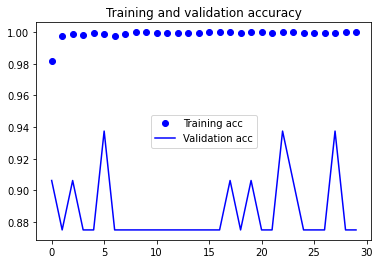

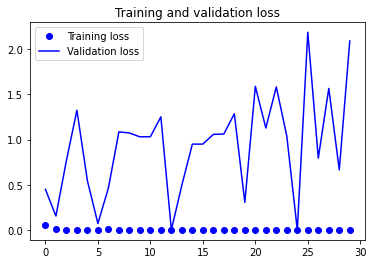

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

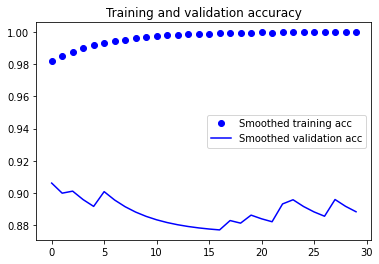

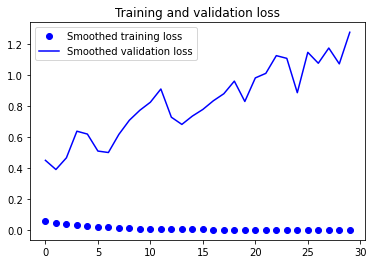

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = VGG16_FT_model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 32 images belonging to 2 classes.
test acc: 0.96875


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np

In [ ]:
ytest_dir = '/content/messy_vs_clean_room/ytest'
from keras.preprocessing.image import ImageDataGenerator
ytest_datagen = ImageDataGenerator(rescale=1./255)
ytest_generator = test_datagen.flow_from_directory(
        ytest_dir,
        target_size=(150, 150),
        batch_size=1,
        class_mode='binary')

pred = VGG16_model.predict_generator(ytest_generator, verbose=1)

predicted_class_indices = np.argmax(pred, axis=1)
labels = (train_generator.class_indices)
label = dict((v,k) for k,v in labels.items())

# 建立代码标签与真实标签的关系
predictions = [label[i] for i in predicted_class_indices]
predictions
#VGG16_model.predict_classes(ytest_generator, batch_size=len(ytest_generator), verbose=0)
#ytest_loss, ytest_acc = VGG16_model.evaluate_generator(ytest_generator, steps=50)
#print('ytest acc:', ytest_acc)

Found 3 images belonging to 2 classes.
3/3 [==============================] - 0s 25ms/step


['clean', 'clean', 'clean']

In [ ]:
![picture]()